# Rockall Trough transport

In [1]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append(r'../') # Add this line at the beginner of each notebook to be able to load local functions 
import src.features.RT_functions as rtf
import src.features.RT_data as rtd
import src.features.RT_transport as rtt
import src.set_paths as sps
import src.RT_parameters as rtp
import src.features.RT_EOF_functions as rt_eof
import src.features.RT_visualise as rtv

In [2]:
import dask
import datetime
import gsw
import scipy
import scipy.io
import cmocean as cm
import numpy as np
import pandas as pd
import seawater as sw
import scipy.signal as signal
import palettable.colorbrewer as cb
import xarray as xr
from pathlib import Path
from scipy.signal import butter, filtfilt
from xhistogram.xarray import histogram as xhist
%matplotlib inline
from matplotlib import pyplot as plt

### Set in- and output path

In [3]:
date_str_start = '201407'
date_str_end = '202207'
fn_out_version = 'v0'
script_name = f"1.0_Rockall_Trough_transports_{date_str_start[:-2]}_{date_str_end[:-2]}_{fn_out_version}"

# output figures
fig_out_path = (sps.local_fig_dir/f"{script_name}")
Path(fig_out_path).mkdir(parents=True, exist_ok=True)

In [4]:
# output data
data_out_path = (sps.local_data_dir/f"{script_name}")
Path(data_out_path).mkdir(parents=True, exist_ok=True)

fn_base = "Rockall_Trough_transport_time_series"
file_name_out = f"{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}.nc"

In [5]:
# intput data
fn_in_version = 'v1'
fn_base_grid = "Rockall_Trough_mooring_gridded_TSUV"
fn_base_stack = "Rockall_Trough_mooring_stacked_TSUV"

RT_mooring_fn = f"{fn_base_grid}_{date_str_start}_{date_str_end}_{fn_in_version}.nc"
file_name_in_stack = f"{fn_base_stack}_{date_str_start}_{date_str_end}_{fn_in_version}.nc"

## Load Data and prepare for calculations

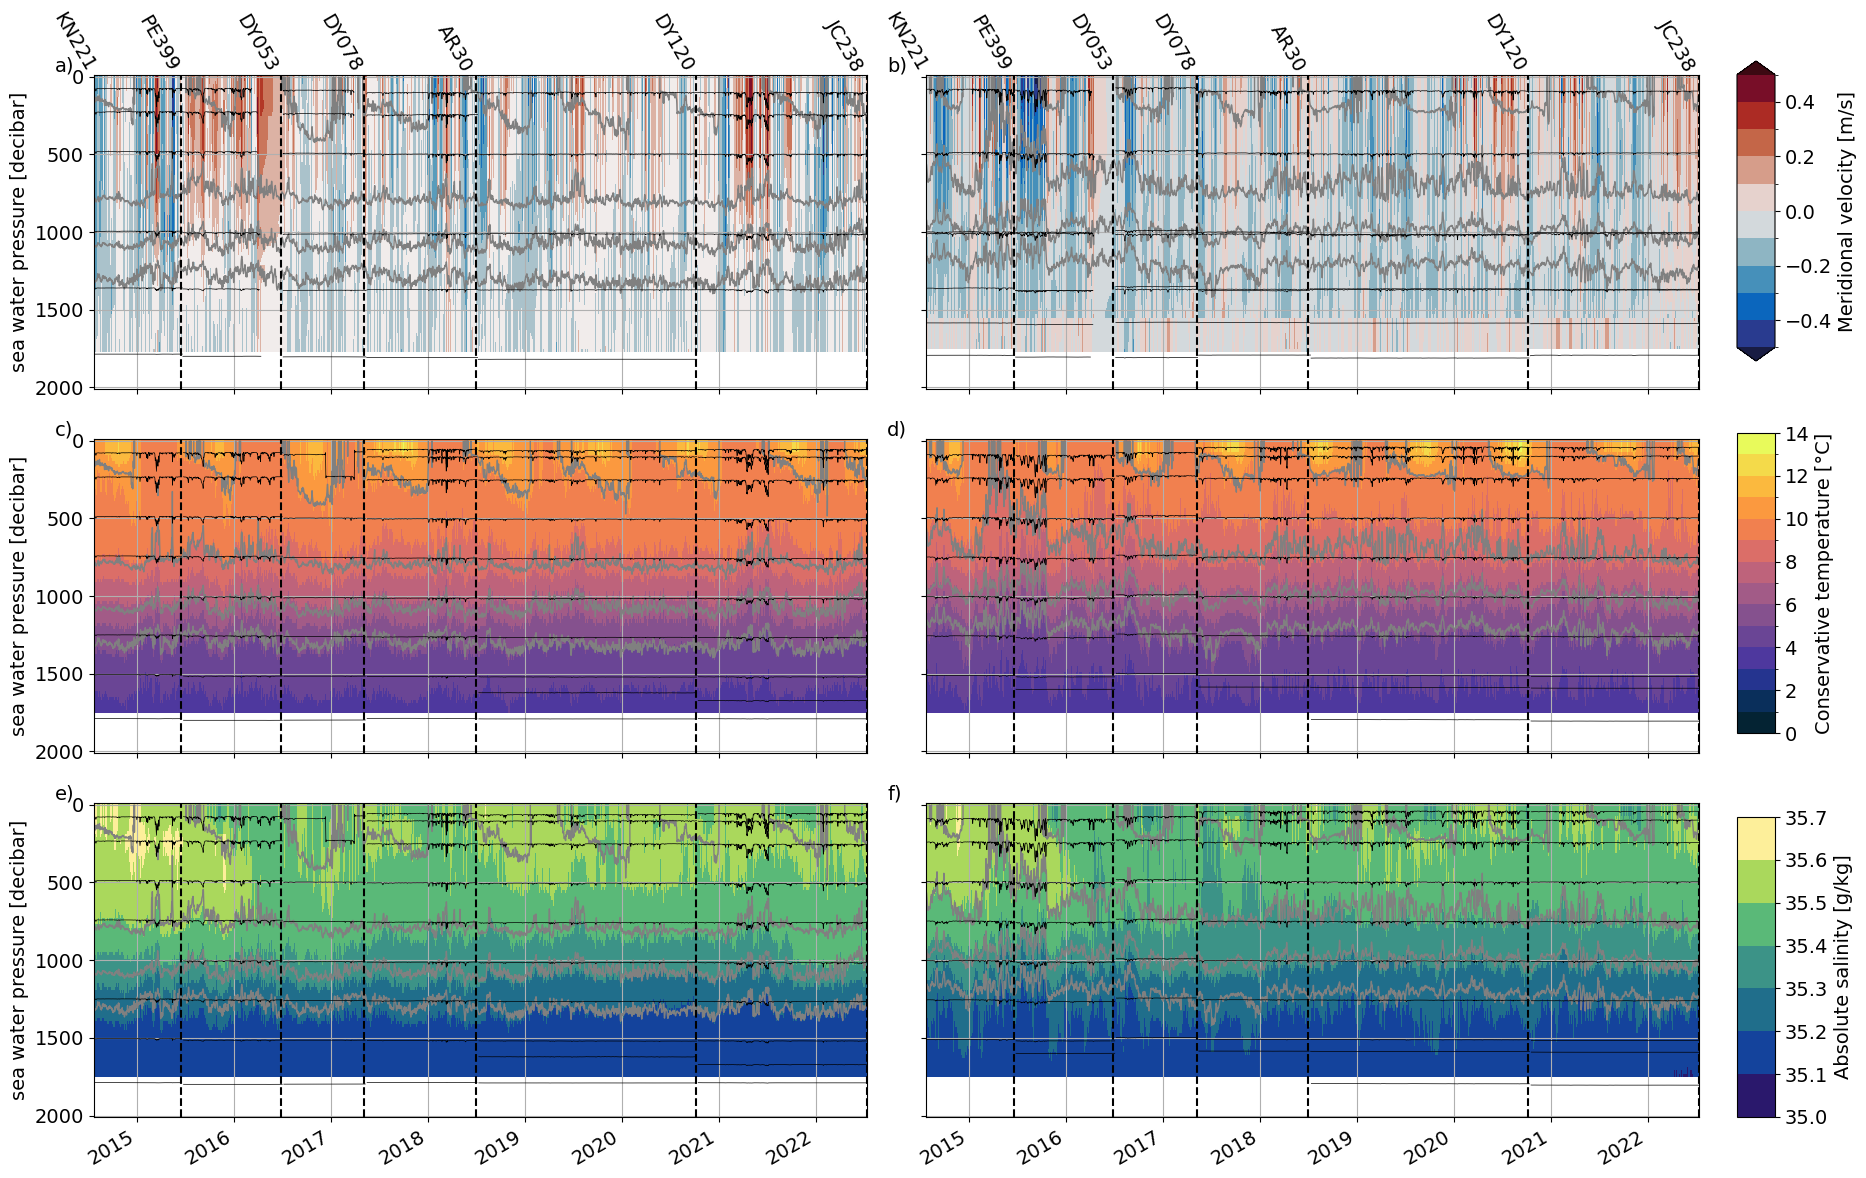

In [7]:
# Rockall Trough mooring location
ds_RT_loc=rtd.load_RT_loc()

# stacked RT mooing data
ds_RT_stacked = xr.open_dataset((sps.RT_mooring_data_path/file_name_in_stack))

# load gridded Rockall Trough mooring data
ds_RT = xr.open_dataset((sps.RT_mooring_data_path/RT_mooring_fn))

# Extrapolate top and linearly interpolate over gaps
ds_RT = rtf.prep_mooring_data_for_transport_calc(ds_RT,ds_RT_loc)

fig = rtv.plot_moorings_paper(ds_RT,ds_RT_stacked)
# fig.savefig(fig_out_path/f'RT_EB_WB_gridded_timeseries_{date_str_start[:-2]}_{date_str_end[:-2]}.png',bbox_inches='tight')


In [8]:
# Load  GEBCO bathymetry
ds_GEBCO = xr.open_dataset((sps.GEBCO_data_path/sps.GEBCO_fn))
ds_GEBCO = ds_GEBCO.where(ds_GEBCO.elevation<=0)

# load GLORYS model data
ds_GLORYS = rtd.load_glorys('RTADCP',ds_RT.TIME.min(),ds_RT.TIME.max())

# load ERA5
ds_ERA5 = xr.open_dataset((sps.ERA5_data_path/sps.ERA5_fn))
ds_ERA5 = ds_ERA5.sel(expver=1).combine_first(ds_ERA5.sel(expver=5))

Data is in GLORYS reanlysis and interim period


# Calculations

## Horizontal and vertical grid parameters

In [9]:
RT_hor_grid = rtt.create_horizontal_grid('v0')

In [10]:
# Get dz (top/bottom cells are ~10m thick, cells are ~20m thick elsewhere)
dz = rtt.get_dz(ds_RT.depth)
ds_RT['dz']=xr.DataArray(dz,dims='depth')

## Midbasin transport based on no motion at 1760 dbar

CPU times: total: 4 s
Wall time: 4 s


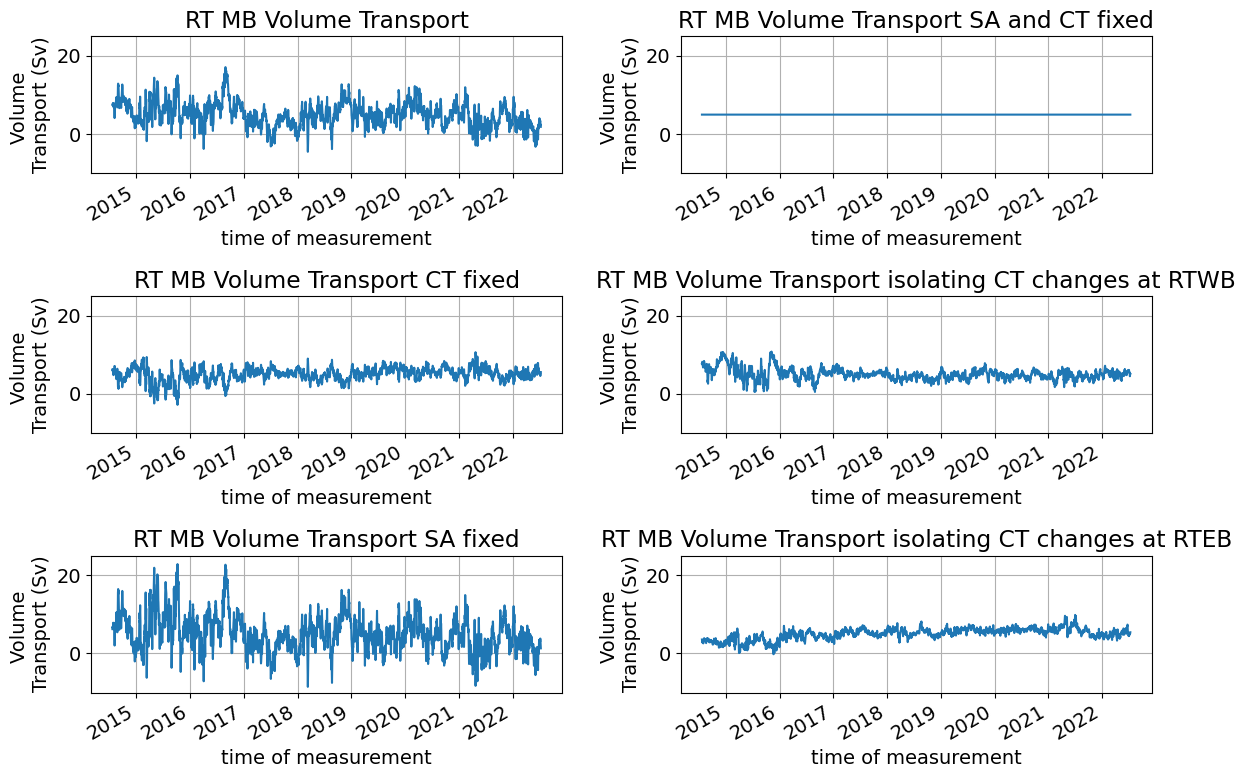

In [11]:
%%time
RT_Q_MB, q_MB = rtt.calc_MB_transport(ds_RT,ds_RT_loc,sens_analysis=True,check_plots=True)

In [54]:
%%time
# # create MB matrix, fine horizontal grid, new and not in Fraser et al. (2022)
ds_RT_MB_grid = rtt.calc_MB_3D_sections(ds_RT,ds_RT_loc,RT_hor_grid)
ds_RT_MB_grid

CPU times: total: 52.2 s
Wall time: 52.4 s


<xarray.Dataset>
Dimensions:  (depth: 101, TIME: 5827, lon: 99)
Coordinates:
    PRES     (depth) float64 0.0 20.19 40.38 60.57 ... 1.988e+03 nan nan
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * TIME     (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat      (lon) float64 57.47 57.46 57.46 57.46 ... 57.11 57.11 57.11 57.1
  * lon      (lon) float64 -12.49 -12.46 -12.43 -12.4 ... -9.638 -9.609 -9.579
    dx       (lon) float64 1.826e+03 1.826e+03 1.827e+03 ... 1.843e+03 1.843e+03
Data variables:
    q        (depth, lon, TIME) float64 826.5 827.8 840.9 848.6 ... nan nan nan
    v        (depth, lon, TIME) float64 0.04526 0.04533 0.04605 ... nan nan nan
    CT       (lon, TIME, depth) float64 10.22 10.22 10.22 10.22 ... nan nan nan
    SA       (lon, TIME, depth) float64 35.56 35.56 35.56 35.56 ... nan nan nan
Attributes:
    name:     depth
    units:    m

## Western wedge transport

CPU times: total: 1min 55s
Wall time: 1min 55s


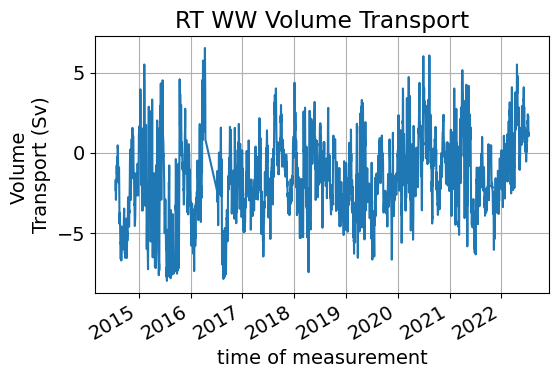

In [18]:
%%time
Q_WW, ds_RT_WW_grid = rtt.calc_WW_transport(ds_RT,ds_RT_loc,RT_hor_grid,ds_GEBCO)
ds_RT_WW_grid

## Eastern wedge

CPU times: total: 16 s
Wall time: 16.4 s


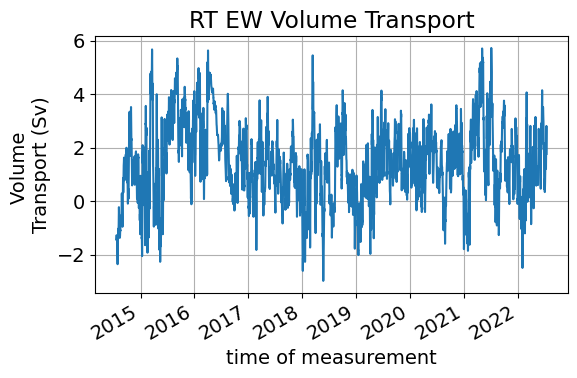

In [28]:
%%time
Q_EW, ds_RT_EW_grid = rtt.calc_EW_transport(ds_RT,ds_RT_loc,RT_hor_grid,ds_GEBCO,ds_GLORYS)

## Ekman transport - monthly mean data

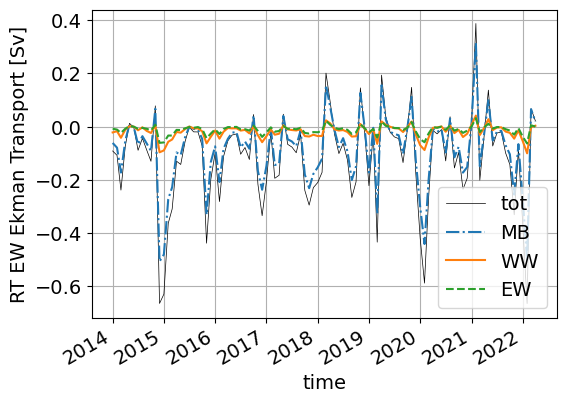

In [31]:
RT_Q_Ek = rtt.calc_Ekman_transport(ds_ERA5, RT_hor_grid,ds_RT_loc,check_plots=True)

In [36]:
print('Total period')
print((RT_Q_Ek.Q_Ek_WW+RT_Q_Ek.Q_Ek_MB+RT_Q_Ek.Q_Ek_EW).mean('time').values)
print('Before 2018')
print((RT_Q_Ek.Q_Ek_WW+RT_Q_Ek.Q_Ek_MB+RT_Q_Ek.Q_Ek_EW).sel(time=slice(None,'2017')).mean('time').values)
print('2018 and beyond')
print((RT_Q_Ek.Q_Ek_WW+RT_Q_Ek.Q_Ek_MB+RT_Q_Ek.Q_Ek_EW).sel(time=slice('2018',None)).mean('time').values)

Total period
-0.11870822477270698
Before 2018
-0.14269872629098265
2018 and beyond
-0.09656314644814487


## Heat and Freshwater Fluxes

In [40]:
# Get SA and CT fields - interpolate for midbasin
ds_RT['SG_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
ds_RT['TG_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

In [43]:
ds_Q_MB,ds_q_MB = rtt.calc_fluxes(RT_Q_MB.RT_Q_MB,q_MB,ds_RT.TG_MB,ds_RT.SG_MB,
                                  ['depth'],'MB')
ds_Q_EW,ds_q_EW = rtt.calc_fluxes(Q_EW,q_EW.q_EW,ds_RT.TG_EAST,ds_RT.SG_EAST,
                                  ['depth','lon_EW'],'EW')
ds_Q_WW,ds_q_WW = rtt.calc_fluxes(Q_WW,q_WW.q_WW,ds_RT.TG_WEST,ds_RT.SG_WEST,
                                  ['depth','lon_WW'],'WW')

In [51]:
ds_q_WW

<xarray.Dataset>
Dimensions:   (lon_WW: 100, depth: 101, TIME: 5827)
Coordinates:
  * lon_WW    (lon_WW) float64 -13.03 -13.03 -13.02 ... -12.52 -12.51 -12.51
    PRES      (depth) float64 0.0 20.19 40.38 60.57 ... 1.988e+03 nan nan
  * depth     (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * TIME      (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat_WW    (lon_WW) float64 57.47 57.47 57.47 57.47 ... 57.47 57.47 57.47
Data variables:
    RT_q_WW   (lon_WW, depth, TIME) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    RT_qh_WW  (lon_WW, depth, TIME) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    RT_qf_WW  (lon_WW, depth, TIME) float64 -0.0 -0.0 -0.0 -0.0 ... nan nan nan
    RT_qS_WW  (lon_WW, depth, TIME) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes:
    description:  Volume, heat, freshwater and salt tranport per grid cell fo...

In [44]:
ds_Q_tot = rtt.combine_sections_tot_transp(ds_Q_WW,ds_Q_MB,ds_Q_EW)

In [45]:
# finer grid MB
# Compute fluxes in each cell
ds_Q_MB_grid,ds_q_MB_grid = rtt.calc_fluxes(RT_Q_MB.RT_Q_MB,ds_RT_MB_grid.q,
                                  ds_RT.TG_MB,ds_RT.SG_MB,
                                  ['depth','lon_MB'],'MB')

In [20]:
# Isolate changes in velocity, mean tracer 
ds_Q1_MB,ds_q1_MB = rtt.calc_fluxes(RT_Q_MB.RT_Q_MB,q_MB,
                ds_RT.TG_MB.mean('TIME'),ds_RT.SG_MB.mean('TIME'),
                ['depth'],'MB_TSfix')
ds_Q1_EW,ds_q1_EW = rtt.calc_fluxes(Q_EW,q_EW,
                ds_RT.TG_EAST.mean('TIME'),ds_RT.SG_EAST.mean('TIME'),
                ['depth','lon_EW'],'EW_TSfix')
ds_Q1_WW,ds_q1_WW = rtt.calc_fluxes(Q_WW,q_WW,
                ds_RT.TG_WEST.mean('TIME'),ds_RT.SG_WEST.mean('TIME'),
                ['depth','lon_WW'],'WW_TSfix')

# Isolate changes in tracer, mean velocity
ds_Q2_MB,ds_q2_MB = rtt.calc_fluxes(RT_Q_MB.RT_Q_MB.mean('TIME'),q_MB.mean('TIME'),
                ds_RT.TG_MB,ds_RT.SG_MB,
                ['depth'],'MB_qfix')
ds_Q2_EW,ds_q2_EW = rtt.calc_fluxes(Q_EW.mean('TIME'),q_EW.mean('TIME'),
                ds_RT.TG_EAST,ds_RT.SG_EAST,
                ['depth','lon_EW'],'EW_qfix')
ds_Q2_WW,ds_q2_WW = rtt.calc_fluxes(Q_WW.mean('TIME'),q_WW.mean('TIME'),
                ds_RT.TG_WEST,ds_RT.SG_WEST,
                ['depth','lon_WW'],'WW_qfix')

RT_Q_MB has length 1, no filter applied
RT_Q_EW has length 1, no filter applied
RT_Q_WW has length 1, no filter applied


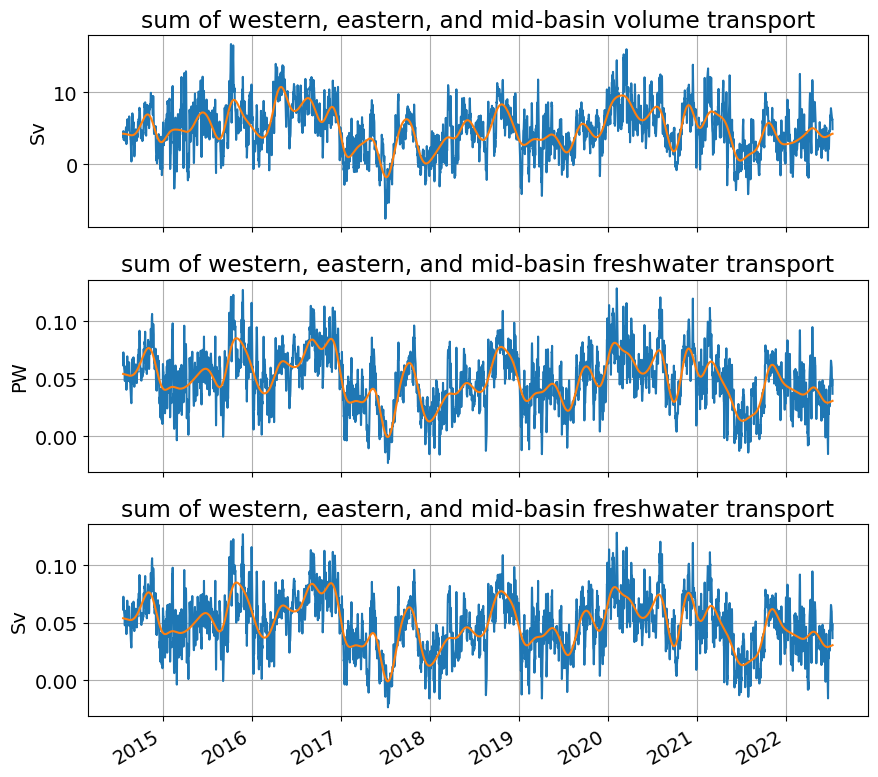

In [21]:
#low pass filter
dt = 0.5 # twice per day, time step of sampling
fs = 1/dt # sample rate (1/day)
lowcut = 1/rtp.filter_length # cut off frequency

ds_Q_MB = rtf.lp_filt_loop(ds_Q_MB,lowcut,fs,'TIME')
ds_Q_EW = rtf.lp_filt_loop(ds_Q_EW,lowcut,fs,'TIME')
ds_Q_WW = rtf.lp_filt_loop(ds_Q_WW,lowcut,fs,'TIME')
ds_Q_tot = rtf.lp_filt_loop(ds_Q_tot,lowcut,fs,'TIME',check_plots=True)

ds_Q1_MB = rtf.lp_filt_loop(ds_Q1_MB,lowcut,fs,'TIME')
ds_Q1_EW = rtf.lp_filt_loop(ds_Q1_EW,lowcut,fs,'TIME')
ds_Q1_WW = rtf.lp_filt_loop(ds_Q1_WW,lowcut,fs,'TIME')

ds_Q2_MB = rtf.lp_filt_loop(ds_Q2_MB,lowcut,fs,'TIME')
ds_Q2_EW = rtf.lp_filt_loop(ds_Q2_EW,lowcut,fs,'TIME')
ds_Q2_WW = rtf.lp_filt_loop(ds_Q2_WW,lowcut,fs,'TIME')

### Standard errors

In [23]:
%%time
ds_Q_MB = rtf.std_error_loop(ds_Q_MB)
ds_Q_EW = rtf.std_error_loop(ds_Q_EW)
ds_Q_WW = rtf.std_error_loop(ds_Q_WW)
ds_Q_tot = rtf.std_error_loop(ds_Q_tot)

'x has 5827 data cycles'

'Integral time scale (days) = 137.9383584441073'

' : Degrees of freedom = 42.24350692386341'

'x has 5827 data cycles'

'Integral time scale (days) = 136.15043570487265'

' : Degrees of freedom = 42.79824717293548'

'x has 5827 data cycles'

'Integral time scale (days) = 396.897790340279'

' : Degrees of freedom = 14.681361654858902'

'x has 5827 data cycles'

'Integral time scale (days) = 138.08014632427884'

' : Degrees of freedom = 42.200129092530005'

'x has 5827 data cycles'

'Integral time scale (days) = 254.98928138935938'

' : Degrees of freedom = 22.85194094532304'

'x has 5827 data cycles'

'Integral time scale (days) = 228.4222115865502'

' : Degrees of freedom = 25.50977840345497'

'x has 5827 data cycles'

'Integral time scale (days) = 620.2858242158431'

' : Degrees of freedom = 9.394056372909075'

'x has 5827 data cycles'

'Integral time scale (days) = 255.1965175840615'

' : Degrees of freedom = 22.833383680796473'

'x has 5827 data cycles'

'Integral time scale (days) = 144.00804952447294'

' : Degrees of freedom = 40.46301591641064'

'x has 5827 data cycles'

'Integral time scale (days) = 146.52420526426107'

' : Degrees of freedom = 39.76817338466924'

'x has 5827 data cycles'

'Integral time scale (days) = 243.57405276625383'

' : Degrees of freedom = 23.922909414295816'

'x has 5827 data cycles'

'Integral time scale (days) = 144.29099706494185'

' : Degrees of freedom = 40.3836699345657'

'x has 5827 data cycles'

'Integral time scale (days) = 275.7928753465784'

' : Degrees of freedom = 21.128174513853672'

'x has 5827 data cycles'

'Integral time scale (days) = 306.1138781846815'

' : Degrees of freedom = 19.03539961845348'

'x has 5827 data cycles'

'Integral time scale (days) = 452.80211503524794'

' : Degrees of freedom = 12.868756144273759'

'x has 5827 data cycles'

'Integral time scale (days) = 276.2090712766659'

' : Degrees of freedom = 21.096338266759396'

'x has 5827 data cycles'

'Integral time scale (days) = 67.42689151570991'

' : Degrees of freedom = 86.419525934135'

'x has 5827 data cycles'

'Integral time scale (days) = 60.90982041208049'

' : Degrees of freedom = 95.66601839535727'

'x has 5827 data cycles'

'Integral time scale (days) = 63.5495475982071'

' : Degrees of freedom = 91.69223417358198'

'x has 5827 data cycles'

'Integral time scale (days) = 67.42561016465989'

' : Degrees of freedom = 86.42116824408264'

'x has 5827 data cycles'

'Integral time scale (days) = 146.65568367099183'

' : Degrees of freedom = 39.73252078707242'

'x has 5827 data cycles'

'Integral time scale (days) = 153.74772412134357'

' : Degrees of freedom = 37.89974800148007'

'x has 5827 data cycles'

'Integral time scale (days) = 156.6539901681124'

' : Degrees of freedom = 37.19662674245824'

'x has 5827 data cycles'

'Integral time scale (days) = 146.68287709749637'

' : Degrees of freedom = 39.72515480540337'

'x has 5827 data cycles'

'Integral time scale (days) = 138.36675040926707'

' : Degrees of freedom = 42.11271842956961'

'x has 5827 data cycles'

'Integral time scale (days) = 125.26087119597324'

' : Degrees of freedom = 46.518916437069464'

'x has 5827 data cycles'

'Integral time scale (days) = 125.26087119597324'

' : Degrees of freedom = 46.518916437069464'

'x has 5827 data cycles'

'Integral time scale (days) = 289.113639337996'

' : Degrees of freedom = 20.154704611454843'

'x has 5827 data cycles'

'Integral time scale (days) = 236.76554683078132'

' : Degrees of freedom = 24.610844263437595'

'x has 5827 data cycles'

'Integral time scale (days) = 236.76554683078132'

' : Degrees of freedom = 24.610844263437595'

CPU times: total: 12min 18s
Wall time: 12min 4s


<xarray.Dataset>
Dimensions:            (TIME: 5827)
Coordinates:
  * TIME               (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-...
Data variables:
    RT_Q_total         (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    RT_Qh_total        (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    RT_Qf_total        (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    RT_Q_total_lp      (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    RT_Qh_total_lp     (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    RT_Qf_total_lp     (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    RT_Q_total_SE      float64 dask.array<chunksize=(), meta=np.ndarray>
    RT_Qh_total_SE     float64 dask.array<chunksize=(), meta=np.ndarray>
    RT_Qf_total_SE     float64 dask.array<chunksize=(), meta=np.ndarray>
    RT_Q_total_lp_SE   float64 dask.array<chunksize=(), meta=np.ndarray>
    RT_Qh_total_lp_SE  float64 dask.array<chunksize=(), meta=np.ndarray>
    RT_Qf_total_lp_SE  float64 dask.array<chunksize=(), meta=np.ndarray>

# Prepare data to save

In [28]:
RT_Q_Qh_Qf = xr.merge([ds_Q_MB,
                      ds_Q_EW,
                      ds_Q_WW,
                      ds_Q_tot,
         ]).drop(['PRES','depth','mask_WW','longitude','latitude','time','mask_EW','lat_MB','lon_MB','mask'])
RT_Q_Qh_Qf

MergeError: conflicting values for variable 'RT_QS_EW' on objects to be combined. You can skip this check by specifying compat='override'.

In [42]:
date_str_start = '201407'
date_str_end = '202207'
global_attrs = {'title' : f'Rockall Trough transport data {date_str_start[-2:]}/{date_str_start[:-2]}-{date_str_end[-2:]}/{date_str_end[:-2]} v0',
'institution' : 'Scottish Association for Marine Science, Scottish Marine Institute Oban, Argyll, PA37 1QA, UK',
'history' : 'Delayed time processed quality controlled',
'description':'Rockall Trough transport. The timeseries is a extended version of the one published in Fraser et al. (2022, JGR Ocean, see references)',
'id' : f'{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}',
'pi':'Stuart Cunningham',
'creator_name' : 'Kristin Burmeister',
'creator_url' : 'https://orcid.org/0000-0003-3881-0298',
'contributor_name' : 'Neil Fraser, Lewis Drysdale, Sam Jones, Stuart Cunningham',
'source' : 'Derived from moored current meter observations and model analysis and reanalysis from GLORYS12V1',
'project' : 'Climate Linked Atlantic Sector Science',
'references' : 'https://doi.org/10.1029/2022JC019291, http://www.o-snap.org',
'area' : 'North Atlantic Ocean',
'time_coverage_start' : f'{RT_Q_Qh_Qf.TIME.min().dt.strftime("%Y-%m-%d %r").values}',
'time_coverage_end' : f'{RT_Q_Qh_Qf.TIME.max().dt.strftime("%Y-%m-%d %r").values}',
'citation' : 'These data were collected and made freely available by the OSNAP project and the national programs that contribute to it.',
'acknowledgement' : 'Funding source: the UK Natural Environment Research Council (NERC), UK OSNAP project', 
'date_created' : datetime.datetime.now().strftime("%Y-%m-%d %r"),
'date_modified' : datetime.datetime.now().strftime("%Y-%m-%d %r")}
RT_Q_Qh_Qf.attrs = global_attrs

In [43]:
RT_Q_Qh_Qf

<xarray.Dataset>
Dimensions:    (TIME: 5827)
Coordinates:
  * TIME       (TIME) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
Data variables: (12/36)
    Q_tot      (TIME) float64 3.827 4.248 4.603 4.268 ... 5.915 5.681 5.313
    Q_tot_lp   (TIME) float64 4.244 4.243 4.242 4.241 ... 4.439 4.445 4.451
    SE_tot     float64 dask.array<chunksize=(), meta=np.ndarray>
    Q_EW       (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    Q_EW_lp    (TIME) float64 dask.array<chunksize=(5827,), meta=np.ndarray>
    SE_EW      float64 dask.array<chunksize=(), meta=np.ndarray>
    ...         ...
    Qf_MB      (TIME) float64 -0.0335 -0.03403 -0.03439 ... -0.00569 -0.004631
    Qf_MB_lp   (TIME) float64 -0.03322 -0.03323 -0.03324 ... 0.000388 0.0003635
    SEf_MB     float64 0.002776
    Qf_WW      (TIME) float64 0.001183 -0.001102 ... -0.003065 -0.004003
    Qf_WW_lp   (TIME) float64 0.002144 0.002161 0.00218 ... -0.004485 -0.004485
    SEf_WW     float64 0.000716
Attributes: (12/19)
    title:                Rockall Trough transport data 07/2014-07/2022 v0
    institution:          Scottish Association for Marine Science, Scottish M...
    history:              Delayed time processed quality controlled
    description:          Rockall Trough transport. The timeseries is a exten...
    id:                   Rockall_Trough_transport_time_series_201407_202207_v0
    pi:                   Stuart Cunningham
    ...                   ...
    time_coverage_start:  2014-07-21 12:00:00 PM
    time_coverage_end:    2022-07-12 12:00:00 PM
    citation:             These data were collected and made freely available...
    acknowledgement:      Funding source: the UK Natural Environment Research...
    date_created:         2024-04-19 12:32:25 PM
    date_modified:        2024-04-19 12:32:25 PM

In [45]:
ds_q_RTMB = ds_q_MB_grid.drop('PRES').rename({'TIME':'time'})

<xarray.Dataset>
Dimensions:   (depth: 101, time: 5827, lon_MB: 99)
Coordinates:
  * depth     (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time      (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat_MB    (lon_MB) float64 57.47 57.46 57.46 57.46 ... 57.11 57.11 57.1
  * lon_MB    (lon_MB) float64 -12.49 -12.46 -12.43 ... -9.638 -9.609 -9.579
    dx_MB     (lon_MB) float64 1.826e+03 1.826e+03 ... 1.843e+03 1.843e+03
Data variables:
    RT_q_MB   (depth, lon_MB, time) float64 826.5 827.8 840.9 ... nan nan nan
    RT_qh_MB  (depth, lon_MB, time) float64 1.087e+10 1.107e+10 ... nan nan
    RT_qf_MB  (depth, lon_MB, time) float64 -5.385 -5.385 -5.44 ... nan nan nan
    RT_qS_MB  (depth, lon_MB, time) float64 28.61 28.66 29.11 ... nan nan nan
Attributes:
    description:  Volume, heat, freshwater and salt tranport per grid cell fo...

In [46]:
ds_q_RTMB = ds_RT_MB_grid.drop('PRES').rename({'TIME':'time'})
ds_q_RTMB = ds_q_RTMB.rename({'lon_MB':'lon','lat_MB':'lat','dx_MB':'dx'})
ds_q_RTMB.coords['dz']=ds_RT.dz
ds_q_RTMB

<xarray.Dataset>
Dimensions:  (depth: 101, time: 5827, lon: 99)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
    lat      (lon) float64 57.47 57.46 57.46 57.46 ... 57.11 57.11 57.11 57.1
  * lon      (lon) float64 -12.49 -12.46 -12.43 -12.4 ... -9.638 -9.609 -9.579
    dx       (lon) float64 1.826e+03 1.826e+03 1.827e+03 ... 1.843e+03 1.843e+03
    PRES     (depth) float64 0.0 20.19 40.38 60.57 ... 1.988e+03 nan nan
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (depth, lon, time) float64 826.5 827.8 840.9 848.6 ... nan nan nan
    CT       (lon, time, depth) float64 10.22 10.22 10.22 10.22 ... nan nan nan
    SA       (lon, time, depth) float64 35.56 35.56 35.56 35.56 ... nan nan nan
Attributes:
    name:     depth
    units:    m

In [45]:
ds_q_RTEW = xr.Dataset()
ds_q_RTEW['q']=(RT_q.reset_coords().q_EW.rename('q')).rename({'lon_EW':'lon'})
ds_q_RTEW.coords['lat']=RT_q.reset_coords().lat_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dx']=dx_EW.rename({'lon_EW':'lon'})
ds_q_RTEW.coords['dz']=dz
mask = ds_q_RTEW.q.notnull()
ds_q_RTEW['CT'] = (ds_RT.TG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW['SA'] = (ds_RT.SG_EAST*ds_q_RTEW.q.notnull()).where(mask)
ds_q_RTEW = ds_q_RTEW.drop('PRES').rename({'TIME':'time'})

In [46]:
ds_q_RTWW = xr.Dataset()
ds_q_RTWW['q']=(RT_q.reset_coords().q_WW.rename('q')).rename({'lon_WW':'lon'})
ds_q_RTWW.coords['lat']=RT_q.reset_coords().lat_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dx']=dx_WW.rename({'lon_WW':'lon'})
ds_q_RTWW.coords['dz']=dz
mask = ds_q_RTWW.q.notnull()
ds_q_RTWW['CT'] = (ds_RT.TG_WEST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW['SA'] = (ds_RT.SG_WEST*ds_q_RTWW.q.notnull()).where(mask)
ds_q_RTWW = ds_q_RTWW.drop('PRES').rename({'TIME':'time'})
ds_q_RTWW

<xarray.Dataset>
Dimensions:  (depth: 101, time: 5827, lon: 100)
Coordinates:
  * depth    (depth) float32 0.0 20.0 40.0 60.0 ... 1.96e+03 1.98e+03 2e+03
  * time     (time) datetime64[ns] 2014-07-21T12:00:00 ... 2022-07-12T12:00:00
  * lon      (lon) float64 -13.03 -13.03 -13.02 -13.02 ... -12.52 -12.51 -12.51
    lat      (lon) float64 57.47 57.47 57.47 57.47 ... 57.47 57.47 57.47 57.47
    dx       (lon) float64 158.3 316.6 316.6 316.6 ... 316.6 316.6 316.6 158.3
    dz       (depth) float32 10.0 20.0 20.0 20.0 20.0 ... 20.0 20.0 20.0 10.0
Data variables:
    q        (lon, depth, time) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    CT       (time, depth, lon) float64 10.22 10.22 10.22 10.22 ... nan nan nan
    SA       (time, depth, lon) float64 35.56 35.56 35.56 35.56 ... nan nan nan

In [47]:
RT_q['dx_EW']=dx_EW
RT_q['dx_WW']=dx_WW
# RT_q['dx_MB']=dx_MB
RT_q['dz']=ds_RT.dz
 
RT_q['SA_MB'] = (ds_RT.SG_WEST + ds_RT.SG_EAST)/2
RT_q['CT_MB'] = (ds_RT.TG_WEST + ds_RT.TG_EAST)/2

mask = RT_q.q_EW.notnull()
RT_q['CT_EW'] = (ds_RT.TG_EAST*RT_q.q_EW.notnull()).where(mask)
RT_q['SA_EW'] = (ds_RT.SG_EAST*RT_q.q_EW.notnull()).where(mask)

mask = RT_q.q_WW.notnull()
RT_q['CT_WW'] = (ds_RT.TG_WEST*RT_q.q_WW.notnull()).where(mask)
RT_q['SA_WW'] = (ds_RT.SG_WEST*RT_q.q_WW.notnull()).where(mask)

In [48]:
RT_Q_Qh_Qf.to_netcdf(f'{data_out_path}/{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
RT_q.to_netcdf(f'{data_out_path}/RT_q_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
RT_Q_Ek.to_netcdf(f'{data_out_path}/RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')

In [49]:
ds_q_RTMB.to_netcdf(f'{data_out_path}/q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
ds_q_RTWW.to_netcdf(f'{data_out_path}/q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
ds_q_RTEW.to_netcdf(f'{data_out_path}/q_RTEW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')

In [50]:
RT_Q_Qh_Qf.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))
RT_q.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/RT_q_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))
RT_Q_Ek.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))

In [51]:
ds_q_RTMB.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))
ds_q_RTWW.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))
ds_q_RTEW.to_netcdf((sps.one_drive_data_dir/f'data_RT_mooring/q_RTEW_times_eries_{date_str_start}_{date_str_end}_{fn_out_version}.nc'))

In [25]:
print('tot transport errors')
print(ds_Q_tot.RT_Q_total_SE.values)
print(ds_Q_tot.RT_Qh_total_SE.values)
print(ds_Q_tot.RT_Qf_total_SE.values)

print('Midbasin non-grid')
print(ds_Q_MB.RT_Q_MB_SE.values)
print(ds_Q_MB.RT_Qh_MB_SE.values)
print(ds_Q_MB.RT_Qf_MB_SE.values)

tot transport errors
0.5253110601757109
0.003686096836887867
0.003686096836887867
Midbasin non-grid
0.48292017572269225
0.0033524562888948397
0.0027763055156918327


### Get depth-accumulated transport

In [22]:
P_ref = ds_RT.where((ds_RT.SG_WEST+ds_RT.SG_EAST).notnull(),
                    drop=True).PRES.max().values
qz_EW = ds_q_EW.RT_q_EW.sum('lon_EW')
qz_WW = ds_q_WW.RT_q_WW.sum('lon_WW')
qz_MB = ds_q_MB.RT_q_MB
qz_MB_grid = ds_q_MB_grid.RT_q_MB.sum('lon_MB')
Q_MB_cumul = qz_MB.sel(depth=slice(None,P_ref))/1e6
Q_MB_grid_cumul = qz_MB_grid.sel(depth=slice(None,P_ref))/1e6
Q_EW_cumul = qz_EW.sel(depth=slice(None,P_ref))/1e6
Q_WW_cumul = qz_WW.sel(depth=slice(None,P_ref))/1e6

### Standard error pre 2017 - check regime shift

In [ ]:
SE_pre_2017 = rtf.std_error(ds_Q_tot.RT_Q_total.sel(TIME=slice(None,'2017')))
SEh_pre_2017 = rtf.std_error(ds_Q_tot.RT_Qh_total.sel(TIME=slice(None,'2017')))
SEf_pre_2017 = rtf.std_error(ds_Q_tot.RT_Qf_total.sel(TIME=slice(None,'2017')))

SE_after_2017 = rtf.std_error(ds_Q_tot.RT_Q_total.sel(TIME=slice('2017',None)))
SEh_after_2017 = rtf.std_error(ds_Q_tot.RT_Qh_total.sel(TIME=slice('2017',None)))
SEf_after_2017 = rtf.std_error(ds_Q_tot.RT_Qf_total.sel(TIME=slice('2017',None)))

In [27]:
Q=ds_Q_tot.RT_Q_total.sel(TIME=slice(None,'2017'))
print(f"Q Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=ds_Q_tot.RT_Qh_total.sel(TIME=slice(None,'2017'))
print(f"Qh Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=ds_Q_tot.RT_Qf_total.sel(TIME=slice(None,'2017'))
print(f"Qf Pre 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")

Q Pre 2017 mean is 5.017001263203661, std dev is 3.6225840003096037, std error is 0.9380089109249787
Qh Pre 2017 mean is 0.05191638235479016, std dev is 0.0259111279327966, std error is 0.005887342766573793
Qf Pre 2017 mean is 0.05191638235479016, std dev is 0.0259111279327966, std error is 0.005887342766573793


In [ ]:
Q=ds_Q_tot.RT_Q_total.sel(TIME=slice('2017',None))
print(f"Q after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SE_pre_2017.values}")
Q=ds_Q_tot.RT_Qh_total.sel(TIME=slice('2017',None))
print(f"Qh after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEh_pre_2017.values}")
Q=ds_Q_tot.RT_Qf_total.sel(TIME=slice('2017',None))
print(f"Qf after 2017 mean is {Q.mean('TIME').values}, std dev is {Q.std('TIME').values}, std error is {SEf_pre_2017.values}")

### Check trends in time-series

In [ ]:
dim = 'TIME'
fit, slope, intc, trend_significant = rtf.detrend_data(ds_Q_tot.RT_Q_total,dim)

# Plot timeseries

In [52]:
RT_Q_Qh_Qf = xr.open_dataset(f'{data_out_path}{fn_base}_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
RT_q = xr.open_dataset(f'{data_out_path}RT_q_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
RT_Q_Ek = xr.open_dataset(f'{data_out_path}RT_Ekman_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')

In [53]:
ds_q_RTMB = xr.open_dataset(f'{data_out_path}q_RTMB_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
ds_q_RTWW = xr.open_dataset(f'{data_out_path}q_RTWW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')
ds_q_RTEW = xr.open_dataset(f'{data_out_path}q_RTEW_time_series_{date_str_start}_{date_str_end}_{fn_out_version}.nc')

## Rockall Trough Volume Transport

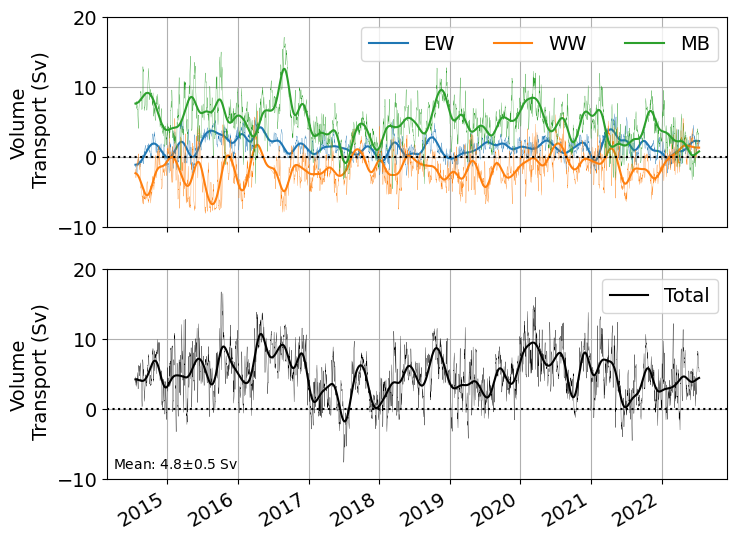

In [54]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Q_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Q_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Q_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Q_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Q_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Q_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[0])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-10, 20])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_volume_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Heat Transport

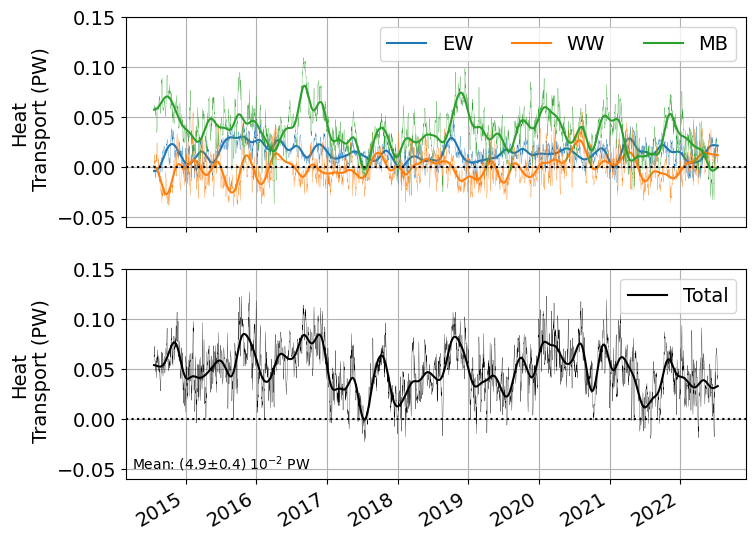

In [55]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

ax=axs[0]
RT_Q_Qh_Qf.Qh_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qh_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qh_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qh_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qh_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qh_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qh_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[1])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .15])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_heat_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Freshwater Transport

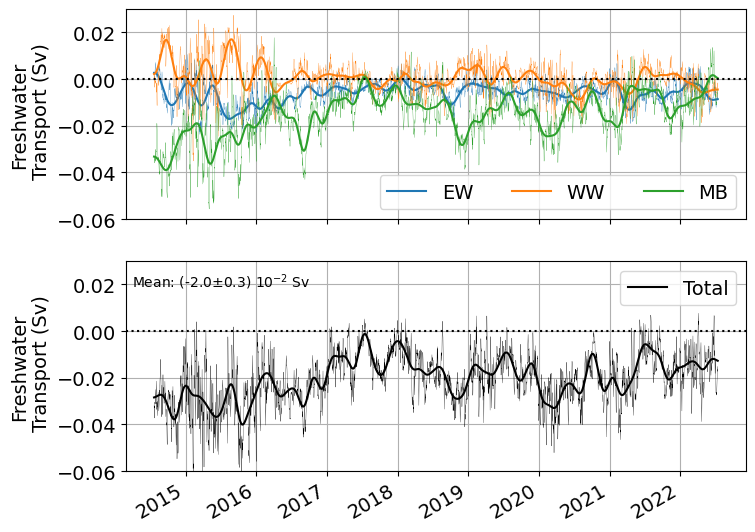

In [56]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .95

ax=axs[0]
RT_Q_Qh_Qf.Qf_EW.plot.line(ax=ax,linewidth=.2,color='C0')
RT_Q_Qh_Qf.Qf_EW_lp.plot.line(ax=ax,color='C0',label='EW')

RT_Q_Qh_Qf.Qf_WW.plot.line(ax=ax,linewidth=.2,color='C1')
RT_Q_Qh_Qf.Qf_WW_lp.plot.line(ax=ax,color='C1',label='WW')

RT_Q_Qh_Qf.Qf_MB.plot.line(ax=ax,linewidth=.2,color='C2')
RT_Q_Qh_Qf.Qf_MB_lp.plot.line(ax=ax,color='C2',label='MB')


ax=axs[1]
RT_Q_Qh_Qf.Qf_tot.plot.line('k',ax=ax,linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('k',ax=ax,label='Total')
ax.text(left, bottom,('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,va='top',
        transform=ax.transAxes)


for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[2])
    ax.set_xlabel('')
    ax.legend(ncol = len(ax.lines))
    ax.set_ylim([-.06, .03])
    ax.axhline(0,color='k',ls=':')

fig.savefig(fig_out_path/f'Rockall_Trough_freshwater_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Total Transport Timeseries

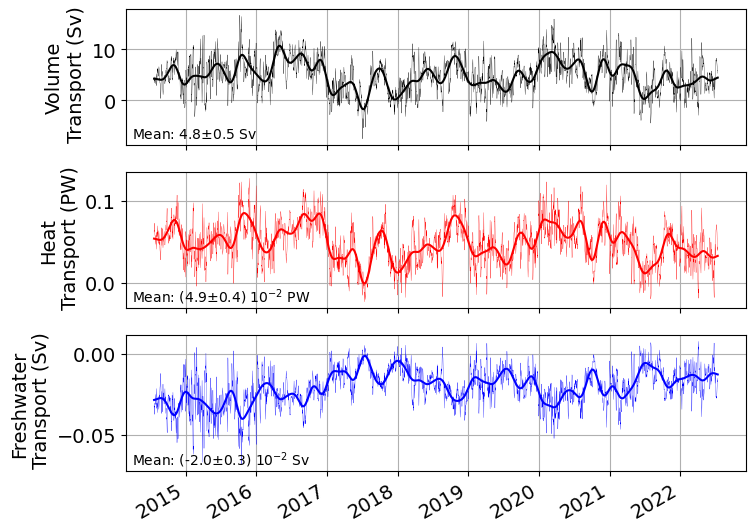

In [57]:
fig,axs = plt.subplots(3,1,sharex=True,figsize=[8,6])

ylabel_name = ['Volume\n Transport (Sv)','Heat\n Transport (PW)','Freshwater\n Transport (Sv)']
# build a rectangle in axes coords
left = .01
bottom = .05

# print(SE.values)
# print(SEh.values)
# print(SEf.values) Q_MB_grid

RT_Q_Qh_Qf.Q_tot.plot.line('k',ax=axs[0],linewidth=.2)
RT_Q_Qh_Qf.Q_tot_lp.plot.line('k',ax=axs[0],)
axs[0].text(left, bottom, ('Mean: %2.1f$\pm$%2.1f Sv' %(RT_Q_Qh_Qf.Q_tot.mean().values,RT_Q_Qh_Qf.SE_tot.values)),
        fontsize=10,
        transform=axs[0].transAxes)

RT_Q_Qh_Qf.Qh_tot.plot.line('r',ax=axs[1],linewidth=.2)
RT_Q_Qh_Qf.Qh_tot_lp.plot.line('r',ax=axs[1],)
axs[1].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ PW' %(RT_Q_Qh_Qf.Qh_tot.mean().values*1e2,RT_Q_Qh_Qf.SEh_tot.values*1e2)),
        fontsize=10,
        transform=axs[1].transAxes)

RT_Q_Qh_Qf.Qf_tot.plot.line('b',ax=axs[2],linewidth=.2)
RT_Q_Qh_Qf.Qf_tot_lp.plot.line('b',ax=axs[2],)
axs[2].text(left, bottom, ('Mean: (%2.1f$\pm$%2.1f) 10$^{-2}$ Sv' %(RT_Q_Qh_Qf.Qf_tot.mean().values*1e2,RT_Q_Qh_Qf.SEf_tot.values*1e2)),
        fontsize=10,
        transform=axs[2].transAxes)

for i,ax in enumerate(axs):
    ax.grid()
    ax.set_title('')
    ax.set_ylabel(ylabel_name[i])
    ax.set_xlabel('')

fig.savefig(fig_out_path/f'Rockall_Trough_total_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

## Rockall Trough Mean Sections

In [58]:
ds_q_RT = xr.concat([ds_q_RTWW,ds_q_RTMB,ds_q_RTEW],'lon')

# ds_GEBCO.elevation.interp(lon=lon_WW, lat=lat_WW).drop(['lon','lat'])
ds_q_RT['bathy']=ds_GEBCO.elevation.interp(lon=ds_q_RT.lon, lat=ds_q_RT.lat)

def calc_SA_CT_sigma0(ds):
    
    sigma0_attrs = {'long_name':'Potential density referenced to 0dbar',
                   'description':'Potential density TEOS-10', 
                 'units':'kg/m^3'}
    
    ds['sigma0'] = xr.apply_ufunc(gsw.sigma0,
                  ds.SA,ds.CT,
                  dask = 'parallelized',output_dtypes=[float,])
    ds.sigma0.attrs = sigma0_attrs
    return ds

ds_q_RT = calc_SA_CT_sigma0(ds_q_RT)
ds_q_RT['v']=(ds_q_RT.q/(ds_q_RT.dx*ds_q_RT.dz))

vel_attrs = {'long_name':'Across section velocity',
                 'units':'m/s'}
CT_attrs = {'long_name':'Conservative temperature',
          'description':'conservative temperature TEOS-10',
          'units':'degC'}
SA_attrs = {'long_name':'Absolute salinity',
        'description':'Absolute salinity TEOS-10',
         'units':'g/kg'}

ds_q_RT.v.attrs = vel_attrs
ds_q_RT.CT.attrs = CT_attrs
ds_q_RT.SA.attrs = SA_attrs

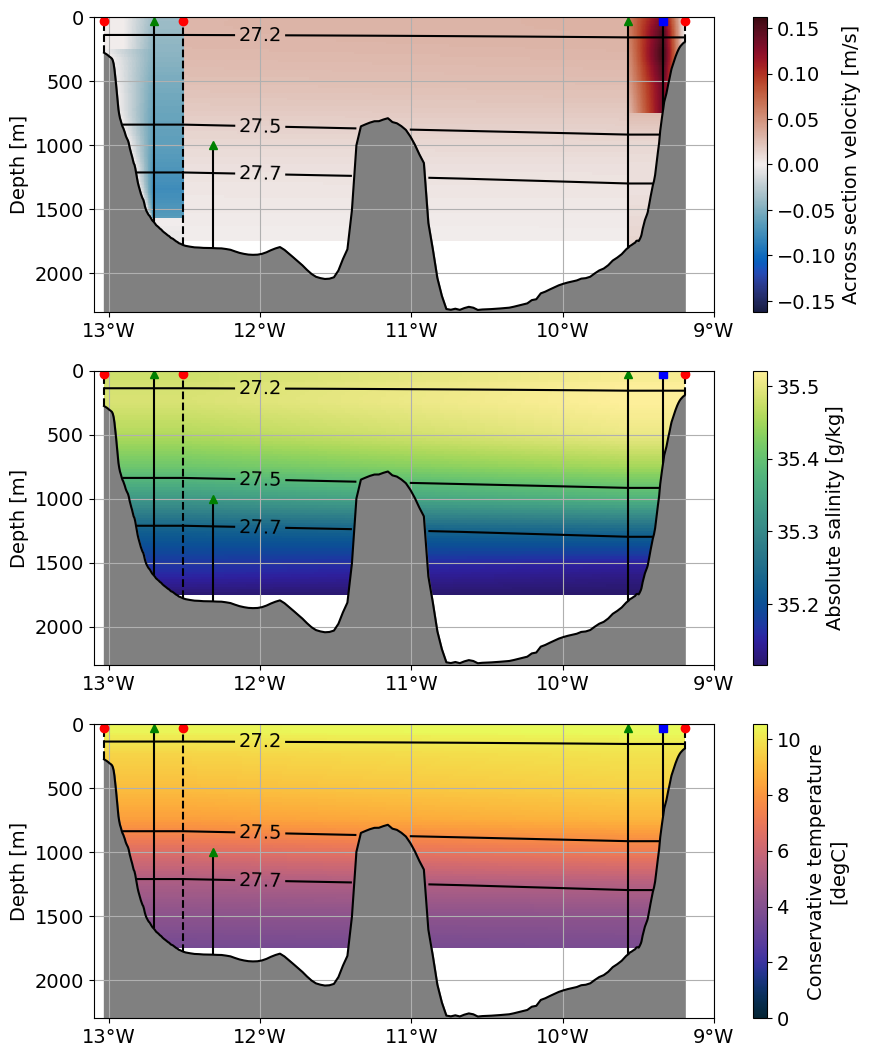

In [59]:
## figure
plt.rcParams.update({'font.size': 14})

xticks = np.arange(-13.,-8,1)
xticklabels = ['13°W','12°W','11°W','10°W','9°W']

sigma_contours = [27.2,27.5, 27.7]
manual_locations = [(-12,100),(-12,900),(-12,1250)]

# Set up figure
fig,axs = plt.subplots(3,1,figsize=[10,13])

ds_q_RT.v.mean('time',keep_attrs=True).plot(ax=axs[0],y='depth',x='lon',yincrease=False,cmap=cm.cm.balance)
ds_q_RT.SA.mean('time',keep_attrs=True).plot(ax=axs[1],y='depth',x='lon',yincrease=False,cmap=cm.cm.haline)
ds_q_RT.CT.mean('time',keep_attrs=True).plot(ax=axs[2],y='depth',x='lon',yincrease=False,cmap=cm.cm.thermal,vmin=0)

for ax in axs:
    ax.fill_between(ds_q_RT.lon, -ds_q_RT.bathy,2300,color='grey')
    (-ds_q_RT.bathy).plot.line('k',ax=ax)
    CS = ds_q_RT.sigma0.mean('time',keep_attrs=True).where(ds_q_RT.depth<=-ds_q_RT.bathy).plot.contour(
        ax=ax,x='lon',levels=sigma_contours,yincrease=False,colors='k')
    ax.clabel(CS,manual=manual_locations)
    
    ax.vlines(ds_RT_loc.lon_RTWB,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(ds_RT_loc.lon_RTES,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTES,method='nearest'), 0,colors='k',ls='--')
    ax.vlines(ds_RT_loc.lon_RTWS,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWS,method='nearest'), 0,colors='k',ls='--')
    
    ax.vlines(ds_RT_loc.lon_RTADCP,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTADCP,method='nearest'), 0,colors='k')
    ax.vlines(ds_RT_loc.lon_RTEB,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTEB,method='nearest'), 50,colors='k')
    ax.vlines(ds_RT_loc.lon_RTWB1,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB1,method='nearest'), 50,colors='k')
    ax.vlines(ds_RT_loc.lon_RTWB2,-ds_q_RT.bathy.sel(lon=ds_RT_loc.lon_RTWB2,method='nearest'), 1000,colors='k')
    
    d= 30.
    ax.plot([ds_RT_loc.lon_RTES,ds_RT_loc.lon_RTWS,ds_RT_loc.lon_RTWB],[d,d,d],'or')
    ax.plot([ds_RT_loc.lon_RTADCP],[d],'sb')
    ax.plot([ds_RT_loc.lon_RTEB,ds_RT_loc.lon_RTWB1],[d,d],'^g')
    ax.plot([ds_RT_loc.lon_RTWB2],[1000],'^g')
    
    ax.set_xlim([-13.1,-9.])
    ax.set_xlabel('')
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels,fontsize=14)
    ax.grid()

    ax.set_ylabel('Depth [m]')
    ax.set_ylim([2300,0])

fig.savefig(fig_out_path/f'Rockall_Trough_mean_sections_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')

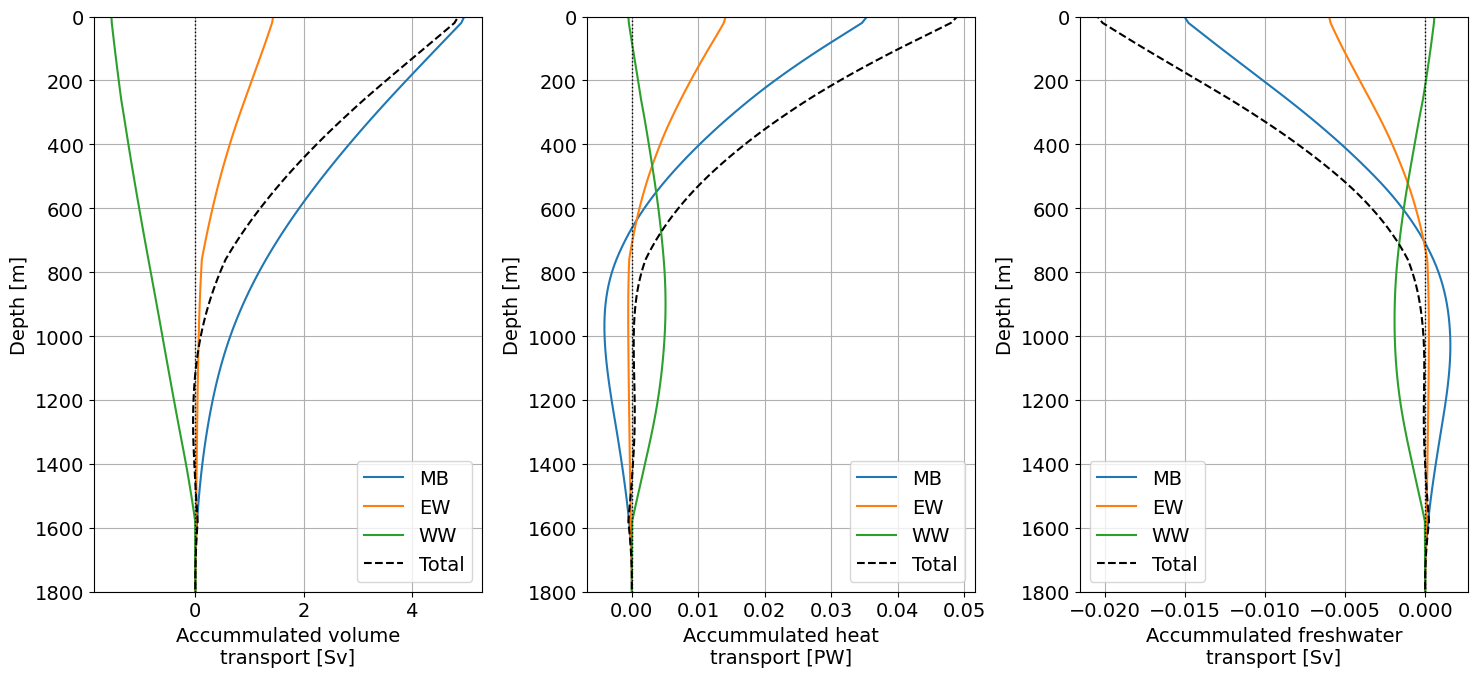

In [60]:
fig,axs = plt.subplots(1,3,figsize=[15,7])
ax=axs[0]
(ds_q_RTMB.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTMB.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(ds_q_RTEW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTEW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(ds_q_RTWW.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RTWW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
(ds_q_RT.q.sum('lon')/1e6).mean(['time']).reindex(depth=ds_q_RT.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated volume\ntransport [Sv]')

ax=axs[1]
(qh_MB_grid.sum('lon_MB')/1e15).mean(['TIME']).reindex(depth=qh_MB_grid.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qh_EW.sum('lon_EW')/1e15).mean(['TIME']).reindex(depth=qh_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qh_WW.sum('lon_WW')/1e15).mean(['TIME']).reindex(depth=qh_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qh_MB_grid.sum('lon_MB')+qh_WW.sum('lon_WW')+(qh_EW.sum('lon_EW')))/1e15)
total.mean(['TIME']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated heat\ntransport [PW]')

ax=axs[2]
(qf_MB_grid.sum('lon_MB')/1e6).mean(['TIME']).reindex(depth=qf_MB_grid.depth[::-1]).cumsum('depth').plot(y='depth',ylim=[1800,0],label='MB',ax=ax)
(qf_EW.sum('lon_EW')/1e6).mean(['TIME']).reindex(depth=qf_EW.depth[::-1]).cumsum('depth').plot(y='depth',label='EW',ax=ax)
(qf_WW.sum('lon_WW')/1e6).mean(['TIME']).reindex(depth=qf_WW.depth[::-1]).cumsum('depth').plot(y='depth',label='WW',ax=ax)
total = ((qf_MB_grid.sum('lon_MB')+qf_WW.sum('lon_WW')+(qf_EW.sum('lon_EW')))/1e6)
total.mean(['TIME']).reindex(depth=total.depth[::-1]).cumsum('depth').plot(y='depth',label='Total',color='k',ls='--',ax=ax)
ax.set_xlabel('Accummulated freshwater\ntransport [Sv]')


for ax in axs:
    ax.axvline(0,ls=':',color='k',lw='1')
    ax.legend()
    ax.set_ylabel('Depth [m]')
    ax.grid()
    ax.set_title('')
plt.tight_layout()

fig.savefig(fig_out_path/f'Rockall_Trough_depth_accumulated_mean_transports_{date_str_start}_{date_str_end}_{fn_out_version}.png',dpi=300,bbox_inches='tight')